In [1]:
from model import get_resnet_feature_extractor, SelfTrainingModel

(feature_extractor, num_features) = get_resnet_feature_extractor(num_blocks=18,
                                                                 pretrained=True,
                                                                 freeze_weights=True)
model = SelfTrainingModel(feature_extractor, num_features,
                          num_classes=5,
                          predict_quality=False,
                          predict_correctness=False)

print(model)

SelfTrainingModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

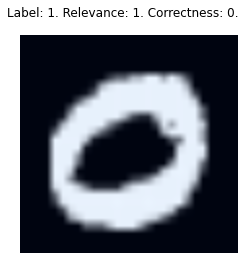

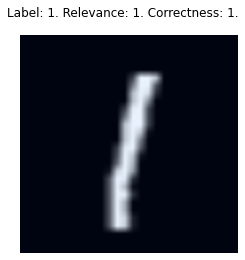

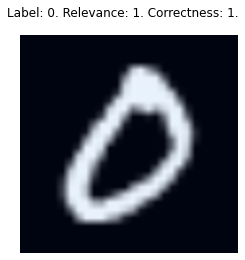

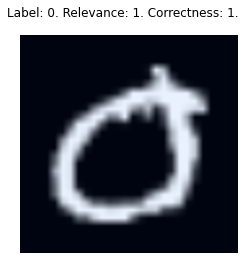

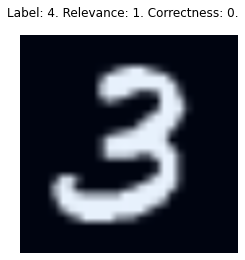

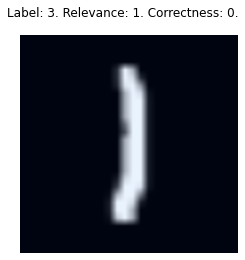

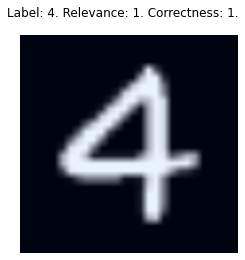

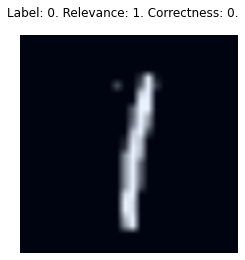

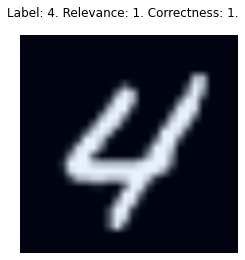

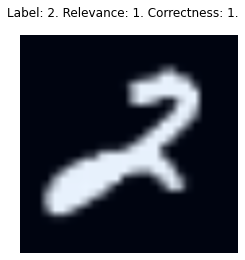

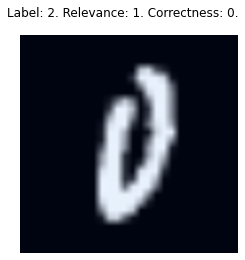

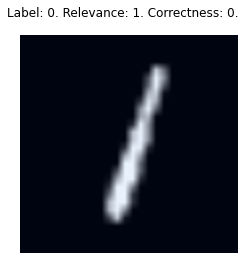

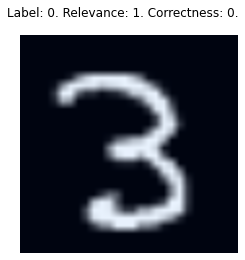

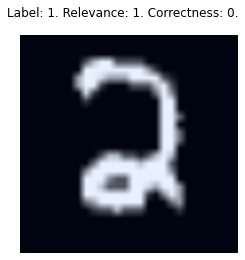

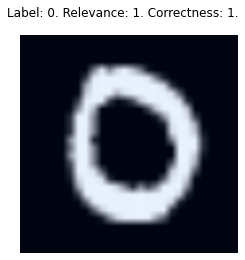

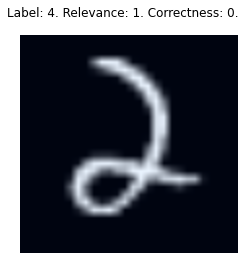

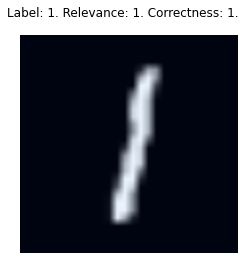

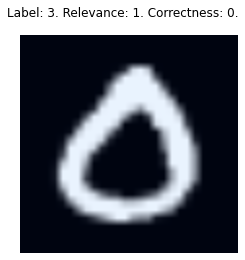

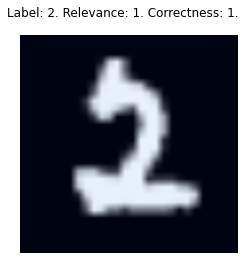

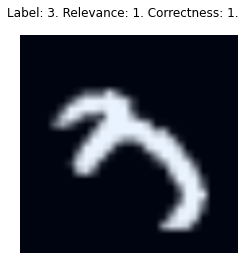

In [2]:
from dataset import LowQualityDataset, GrayscaleToRgb
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

batch_size=32
relevant_classes = [0, 1, 2, 3, 4]
irrelevant_classes = []
proportion_correct = .5

data_transform = transforms.Compose([transforms.ToTensor(),
                                     GrayscaleToRgb(),
                                     transforms.Resize((224, 224)),
                                     transforms.Normalize(mean=[.485, .456, .406],
                                                          std=[.229, .224, .225])])
target_transform = None
relevance_transform = None
correctness_transform = None

mnist_training_dataset = datasets.MNIST(root='./data',
                                        train=True,
                                        download=True,
                                        transform=None)
low_quality_training_dataset = LowQualityDataset(mnist_training_dataset,
                                                 relevant_classes=relevant_classes,
                                                 irrelevant_classes=irrelevant_classes,
                                                 proportion_correct=proportion_correct,
                                                 data_transform=data_transform,
                                                 target_transform=target_transform,
                                                 relevance_transform=relevance_transform,
                                                 correctness_transform=correctness_transform)
low_quality_training_dataloader = DataLoader(low_quality_training_dataset,
                                             batch_size=batch_size,
                                             shuffle=True)

mnist_testing_dataset = datasets.MNIST(root='./data',
                                       train=False,
                                       download=True,
                                       transform=None)
low_quality_testing_dataset = LowQualityDataset(mnist_testing_dataset,
                                                relevant_classes=relevant_classes,
                                                irrelevant_classes=[],
                                                data_transform=data_transform,
                                                target_transform=target_transform,
                                                relevance_transform=relevance_transform,
                                                correctness_transform=correctness_transform)
low_quality_testing_dataloader = DataLoader(low_quality_testing_dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

low_quality_training_dataset.display_examples(20)

In [ ]:
import numpy as np
from tqdm import tqdm
from torch import nn, optim
from train import naive_train_on_batch, naive_eval_on_batch

num_epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = 'cuda'
model = model.to(device)

Results = {'train_loss': [],
           'test_loss': [],
           'train_acc': [],
           'test_acc': []}

print('Calculating initial model performance...')
train_loss_over_epoch = []
train_acc_over_epoch = []
for batch in tqdm(low_quality_training_dataloader):
    loss, acc = naive_eval_on_batch(batch, model, loss_fn, device)
    train_loss_over_epoch.append(loss)
    train_acc_over_epoch.append(acc)
Results['train_loss'].append(np.mean(train_loss_over_epoch))
Results['train_acc'].append(np.mean(train_acc_over_epoch))
# Evaluate over all batches in testing dataset and record performance
test_loss_over_epoch = []
test_acc_over_epoch = []
for batch in tqdm(low_quality_testing_dataloader):
    loss, acc = naive_eval_on_batch(batch, model, loss_fn, device)
    test_loss_over_epoch.append(loss)
    test_acc_over_epoch.append(acc)
Results['test_loss'].append(np.mean(test_loss_over_epoch))
Results['test_acc'].append(np.mean(test_acc_over_epoch))
print('\tTraining loss: %e'%(Results['train_loss'][-1]))
print('\tTraining accuracy: %f'%(100*Results['train_acc'][-1]))
print('\tTesting loss: %e'%(Results['test_loss'][-1]))
print('\tTesting accuracy: %f'%(100*Results['test_acc'][-1]))

for epoch in range(num_epochs):
    print('Beginning epoch %d...'%(epoch+1))
    
    # Train over all batches in training dataset and record performance
    train_loss_over_epoch = []
    train_acc_over_epoch = []
    for batch in tqdm(low_quality_training_dataloader):
        loss, acc = naive_train_on_batch(batch, model, loss_fn, optimizer, device)
        train_loss_over_epoch.append(loss)
        train_acc_over_epoch.append(acc)
    Results['train_loss'].append(np.mean(train_loss_over_epoch))
    Results['train_acc'].append(np.mean(train_acc_over_epoch))
    
    # Evaluate over all batches in testing dataset and record performance
    test_loss_over_epoch = []
    test_acc_over_epoch = []
    for batch in tqdm(low_quality_testing_dataloader):
        loss, acc = naive_eval_on_batch(batch, model, loss_fn, device)
        test_loss_over_epoch.append(loss)
        test_acc_over_epoch.append(acc)
    Results['test_loss'].append(np.mean(test_loss_over_epoch))
    Results['test_acc'].append(np.mean(test_acc_over_epoch))
    
    # Report results
    print('\tTraining loss: %e'%(Results['train_loss'][-1]))
    print('\tTraining accuracy: %f'%(100*Results['train_acc'][-1]))
    print('\tTesting loss: %e'%(Results['test_loss'][-1]))
    print('\tTesting accuracy: %f'%(100*Results['test_acc'][-1]))

Calculating initial model performance...


100%|█████████████████████████████████████████████████████████████████████████████████| 161/161 [00:09<00:00, 17.67it/s]


	Training loss: 1.741496e+00
	Training accuracy: 20.167189
	Testing loss: 1.731667e+00
	Testing accuracy: 21.974093
Beginning epoch 1...


100%|█████████████████████████████████████████████████████████████████████████████████| 161/161 [00:09<00:00, 17.62it/s]


	Training loss: 1.481292e+00
	Training accuracy: 44.354101
	Testing loss: 8.263277e-01
	Testing accuracy: 93.193241
Beginning epoch 2...


100%|█████████████████████████████████████████████████████████████████████████████████| 161/161 [00:09<00:00, 17.61it/s]


	Training loss: 1.456561e+00
	Training accuracy: 46.287226
	Testing loss: 7.712327e-01
	Testing accuracy: 93.457829
Beginning epoch 3...


100%|█████████████████████████████████████████████████████████████████████████████████| 161/161 [00:09<00:00, 17.49it/s]


	Training loss: 1.447261e+00
	Training accuracy: 46.995820
	Testing loss: 8.401360e-01
	Testing accuracy: 84.199289
Beginning epoch 4...


100%|█████████████████████████████████████████████████████████████████████████████████| 161/161 [00:09<00:00, 17.15it/s]


	Training loss: 1.446548e+00
	Training accuracy: 46.946839
	Testing loss: 7.978415e-01
	Testing accuracy: 92.934783
Beginning epoch 5...


100%|█████████████████████████████████████████████████████████████████████████████████| 161/161 [00:09<00:00, 17.11it/s]


	Training loss: 1.446271e+00
	Training accuracy: 46.623563
	Testing loss: 8.013711e-01
	Testing accuracy: 95.749224
Beginning epoch 6...


100%|█████████████████████████████████████████████████████████████████████████████████| 161/161 [00:09<00:00, 17.19it/s]


	Training loss: 1.441450e+00
	Training accuracy: 46.826019
	Testing loss: 8.930170e-01
	Testing accuracy: 79.424444
Beginning epoch 7...


100%|█████████████████████████████████████████████████████████████████████████████████| 161/161 [00:09<00:00, 17.16it/s]


	Training loss: 1.440951e+00
	Training accuracy: 46.982759
	Testing loss: 7.487724e-01
	Testing accuracy: 96.215062
Beginning epoch 8...


100%|█████████████████████████████████████████████████████████████████████████████████| 161/161 [00:09<00:00, 16.95it/s]


	Training loss: 1.438122e+00
	Training accuracy: 47.188480
	Testing loss: 8.206631e-01
	Testing accuracy: 93.711180
Beginning epoch 9...


100%|█████████████████████████████████████████████████████████████████████████████████| 161/161 [00:09<00:00, 17.12it/s]


	Training loss: 1.439273e+00
	Training accuracy: 47.051332
	Testing loss: 8.222591e-01
	Testing accuracy: 91.976545
Beginning epoch 10...


 45%|████████████████████████████████████▋                                            | 434/957 [00:26<00:31, 16.40it/s]

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = plt.gca()
ax.set_title('Loss over time')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot(Results['train_loss'], '--', color='blue', label='Training loss')
ax.plot(Results['test_loss'], '-', color='blue', label='Testing loss')
ax.legend()

fig = plt.figure()
ax = plt.gca()
ax.set_title('Accuracy over time')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot(Results['train_acc'], '--', color='blue', label='Training accuracy')
ax.plot(Results['test_acc'], '-', color='blue', label='Testing accuracy')
ax.legend()

In [ ]:
import os
import pickle
import torch
import shutil

results_dir = os.path.join('.', 'results', 'mnist__irelev_0__incorrect_50')
if not(os.path.exists(results_dir)):
    os.mkdir(results_dir)

with open(os.path.join(results_dir, 'results.pickle'), 'wb') as F:
    pickle.dump(Results, F)

torch.save(model.state_dict(), os.path.join(results_dir, 'trained_model'))

shutil.copy(os.path.join('.', 'trial.ipynb'), os.path.join(results_dir, 'trial.ipynb'))